In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import f_classif

from ISLP import load_data
from ISLP.models import summarize

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
Wage = load_data('Wage')
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
age = Wage['age'].to_numpy()
age_data = pd.DataFrame({f'age^{i}': age**i for i in range(1, 11)})
y = Wage['wage']

age_data.head()

,age^1,age^2,age^3,age^4,age^5,age^6,age^7,age^8,age^9,age^10
0,18,324,5832,104976,1889568,34012224,612220032,11019960576,198359290368,3570467226624
1,24,576,13824,331776,7962624,191102976,4586471424,110075314176,2641807540224,63403380965376
2,45,2025,91125,4100625,184528125,8303765625,373669453125,16815125390625,756680642578125,34050628916015625
3,43,1849,79507,3418801,147008443,6321363049,271818611107,11688200277601,502592611936843,21611482313284249
4,50,2500,125000,6250000,312500000,15625000000,781250000000,39062500000000,1953125000000000,97656250000000000


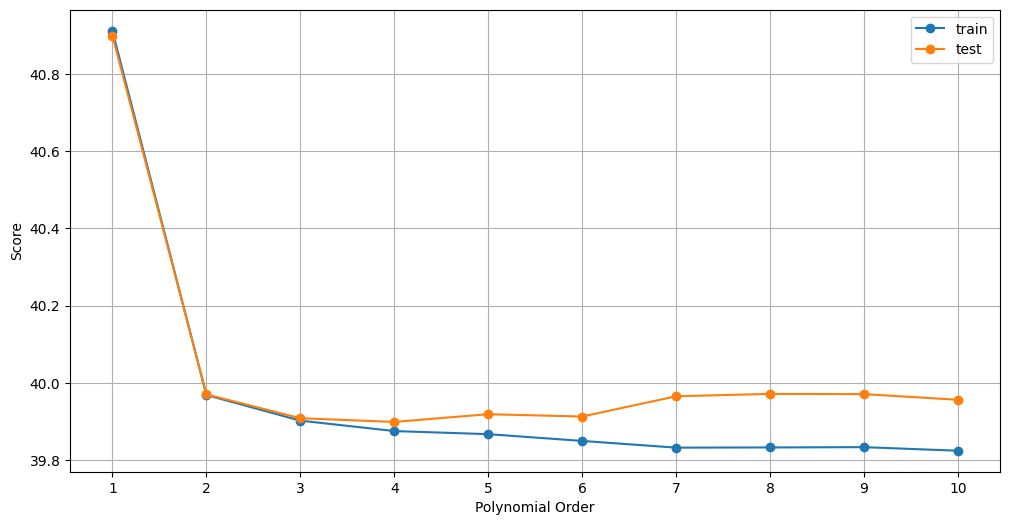

In [4]:
lrg = LinearRegression()

columns = age_data.columns.to_list()

train_scores = []
test_scores = []
for i in range(1, len(columns)+1):
    cv_results = cross_validate(lrg, age_data[columns[:i]], y, cv=5, return_train_score=True, scoring='neg_root_mean_squared_error')
    train_scores.append(-cv_results['train_score'].mean())
    test_scores.append(-cv_results['test_score'].mean())

orders = range(1, 11)

plt.figure(figsize=(12, 6))
plt.plot(orders, train_scores, marker='o', label='train')
plt.plot(orders, test_scores, marker='o', label='test')
plt.xlabel('Polynomial Order')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.xticks(range(1, 11));

Text(0, 0.5, 'wage')

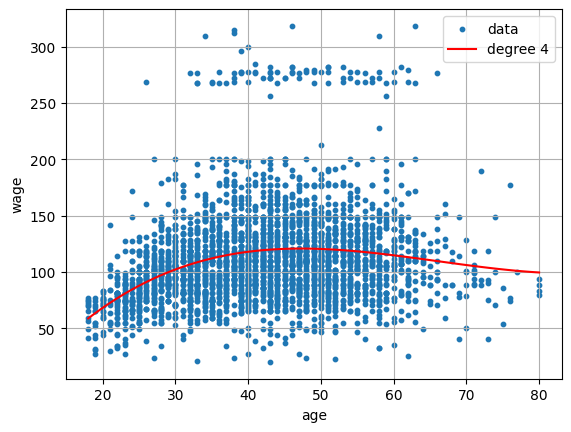

In [5]:
# Plot the data with the best polynomial

best_degree = 3

lrg = LinearRegression()
lrg.fit(age_data[columns[:best_degree]], y)

x_vals = np.linspace(min(age), max(age), 100)
X = [[x,x**2,x**3] for x in x_vals]
y_vals = lrg.predict(X)

plt.scatter(age, y, s=10, label='data')
plt.plot(x_vals, y_vals, c='r', label='degree 4')
plt.legend()
plt.grid()
plt.xlabel('age')
plt.ylabel('wage')

In [6]:
# ANOVA
f_stats, p_vals = f_classif(age_data, y)

print('degree - f - p')
for degree, f, p in zip(range(1, 11), f_stats, p_vals):
    print(degree, f, p)

degree - f - p
1 1.3821373688851464 5.346951623405307e-07
2 1.220398166846004 0.0014948721665153345
3 1.0964562400420996 0.08613640302690574
4 0.9982644871052713 0.5039877925762095
5 0.9148902506817119 0.8966786005570081
6 0.8391825348106441 0.9934260026598403
7 0.7677196903565378 0.9998959064349754
8 0.6995880084398355 0.9999996576721675
9 0.6350687110016785 0.999999999788982
10 0.706852087306049 0.9999993080262485


In [7]:
# From the ANOVA statistics, the relevant features are the ones that correspond to degree 1, 2 and 3

In [26]:
# Step function

min_age = min(age)
max_age = max(age)
num_of_cuts = 2 # a number greater than or equal to zero (and hopefully less than the size of the data)

# Divide the age axis in (num_of_cats + 1) equal parts, based on quantiles
cut_age = pd.qcut(age, num_of_cuts)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 42.0]",105.4767,1.062,99.299,0.0
"(42.0, 80.0]",118.0057,1.069,110.430,0.0


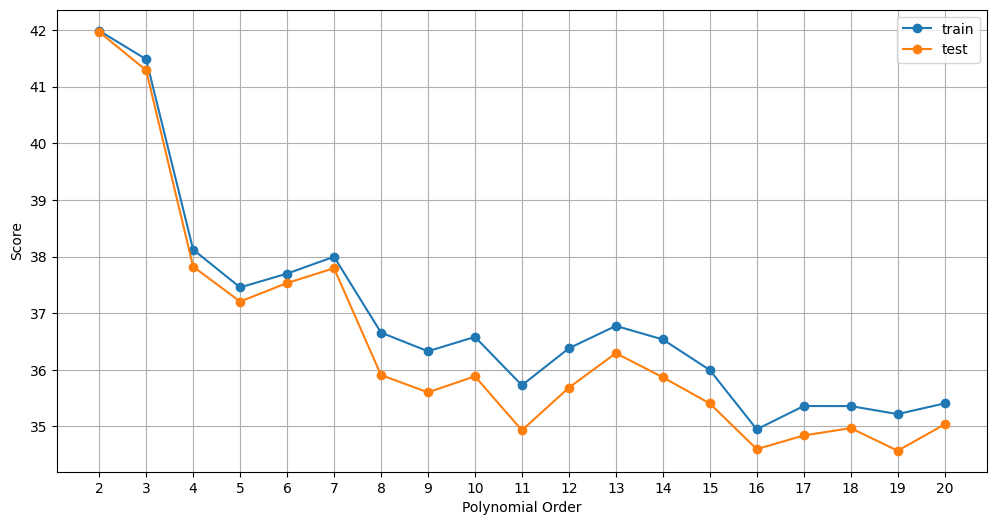

In [119]:
# Perform cross validation to select the best number of cuts

lrg = LinearRegression()

num_cuts = range(2, 21)

train_scores = []
test_scores = []
for n in num_cuts:
    current_train = []
    current_test = []
    cut_age = pd.cut(age, n)
    for interval, count in pd.DataFrame(cut_age).groupby(cut_age).size().iteritems():
        a, b = interval.left, interval.right
        cv_results = cross_validate(lrg, np.ones(count).reshape(-1,1), y[(a < age) & (age <= b)], cv=5, return_train_score=True, scoring='neg_root_mean_squared_error')
        current_train.append(-cv_results['train_score'].mean())
        current_test.append(-cv_results['test_score'].mean())

    train_scores.append(sum(current_train)/len(current_train))
    test_scores.append(sum(current_test)/len(current_test))

# orders = range(1, 11)

plt.figure(figsize=(12, 6))
plt.plot(num_cuts, train_scores, marker='o', label='train')
plt.plot(num_cuts, test_scores, marker='o', label='test')
plt.xlabel('Polynomial Order')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.xticks(num_cuts);

Text(0, 0.5, 'wage')

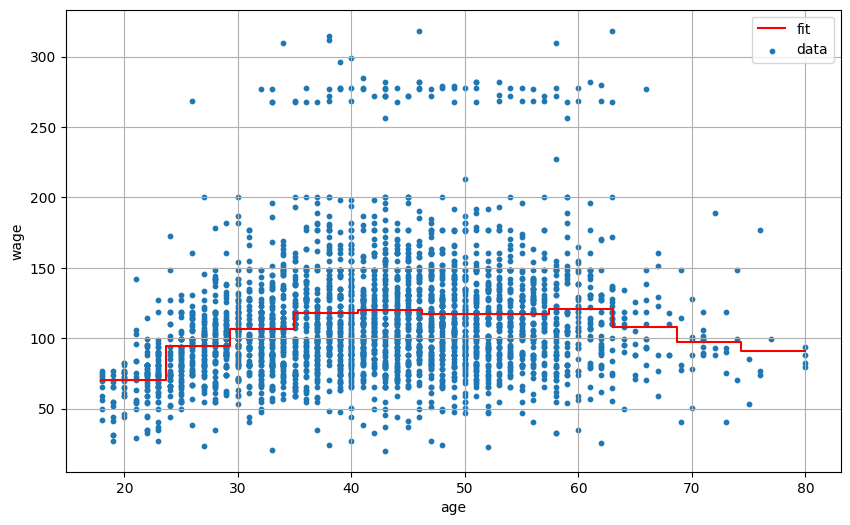

In [120]:
num_of_cuts = 11
cut_age = pd.cut(age, num_of_cuts)

all_x = []
all_y = []
for interval, count in pd.DataFrame(cut_age).groupby(cut_age).size().iteritems():
    a, b = interval.left, interval.right
    lrg = LinearRegression()
    lrg.fit(np.ones(count).reshape(-1,1), y[(a < age) & (age <= b)])
    x_vals = np.linspace(a, b, 20)
    y_vals = lrg.predict(x_vals.reshape(-1,1))
    all_x.extend(x_vals)
    all_y.extend(y_vals)

plt.figure(figsize=(10,6))
plt.plot(all_x, all_y, c='r', label='fit')
plt.scatter(age, y, s=10, label='data')
plt.legend()
plt.grid()
plt.xlabel('age')
plt.ylabel('wage')